In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

#### Reading data

In [2]:
df = pd.read_csv("./resnet50_stats.csv")

#### Extract kernel types

In [3]:
# Controls whether all of the mlir generated kernels will be grouped 
GROUP_MLIR_GEN = True 

# New kernels' categories should be added here
CATEGORIES_PATTERNS = {'main_kernel' : r'main_kernel',
        'hipBLASlt' : r'Cijk',
        'miopen' : r'miopen',
        'implicit_gemm' : r'igemm_|implicit_gemm',
        'composable_kernel' : r'ck',
        'eigen' : r'EigenMetaKernel',
        'fusion_kernel' : r'Fused|fused|fusion',
        'ApplyAdaMomKernel' : r'ApplyAdaMomKernel',
        'FillPhiloxRandomKernel' : r'FillPhiloxRandomKernelLaunch',
        'ColumnReduceKernel' : r'ColumnReduceKernel',
        'ColumnReduceSimpleKernel' : r'ColumnReduceSimpleKernel',
        'ColumnReduceMax16ColumnsKernel' : r'ColumnReduceMax16ColumnsKernel',
        'RowReduceKernel' : r'RowReduceKernel',
        'RowReduceSimpleKernel' : r'RowReduceSimpleKernel',
        'BlockReduceKernel' : r'BlockReduceKernel',
        'Gather' : r'GatherOp',
        'Transpose' : r'transpose',
        'mlir_generated' : r'_GPU_',
        'amd_rocclr' : r'amd_rocclr',
        'rocprim' : r'rocprim',
        }

MLIR_GENERATED = {'Mul' : r'Mul_GPU',
                'AddV2' : r'AddV2_GPU',
                'Div' : r'Div_GPU',
                'DivNoNan' : r'DivNoNan_GPU',
                'Cast' : r'Cast_GPU',
                'Sub' : r'Sub_GPU',
                'Tanh' : r'Tanh_GPU',
                'Equal' : r'^Equal_GPU',
                'NotEqual' : r'NotEqual_GPU',
                'LessEqual' : r'LessEqual_GPU',
                'Less' : r'Less_GPU',
                'GreaterEqual' : r'GreaterEqual_GPU',
                'Greater' : r'Greater_GPU',
                'IsNan' : r'IsNan_GPU',
                'IsInf' : r'IsInf_GPU',
                'Cos' : r'Cos_GPU',
                'Sin' : r'Sin_GPU',
                }

if not GROUP_MLIR_GEN:
    del CATEGORIES_PATTERNS['mlir_generated']
    CATEGORIES_PATTERNS.update(MLIR_GENERATED)


In [4]:
df_cat = pd.DataFrame(columns=['Type', 'TotalCalls', 'TotalDurationNs', 'TotalPercentage'])
for category in CATEGORIES_PATTERNS:
    matched = df[df['Name'].str.contains(CATEGORIES_PATTERNS[category])]
    if matched.empty:
        continue
    df.drop(matched.index, inplace=True)
    calls = matched['Calls'].sum()
    duration = matched['TotalDurationNs'].sum()
    percentage = matched['Percentage'].sum()
    df_cat = pd.concat([pd.DataFrame([[category, calls, duration, percentage]], 
                                     columns=df_cat.columns), df_cat], ignore_index=True)
calls = df['Calls'].sum()
duration = df['TotalDurationNs'].sum()
percentage = df['Percentage'].sum()
df_cat = pd.concat([pd.DataFrame([['Other', calls, duration, percentage]], 
                                     columns=df_cat.columns), df_cat], ignore_index=True)

/tmp/ipykernel_1697344/986162813.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_cat = pd.concat([pd.DataFrame([[category, calls, duration, percentage]],


#### "Other" kernels
Kernels currently not categorized

In [5]:
df

,Name,Calls,TotalDurationNs,AverageNs,Percentage
11,SubTensorOpWithScalar1d.kd,617480,2401103175,3888,2.777993
12,void stream_executor::gpu::launchInplaceBiasAc...,140000,1825642113,13040,2.112205
46,select_and_scatter_4684_0.kd,5000,220421572,44084,0.255020
52,Im2d2Col_v2.kd,27648,200808577,7263,0.232329
144,Col2Im2dU.kd,7168,55839291,7790,0.064604
308,xla::gpu::buffer_comparator::(anonymous namesp...,943,4934715,5232,0.005709
355,xla::gpu::repeat_buffer_kernel::(anonymous nam...,299,1472479,4924,0.001704


#### Plot results

In [7]:
sorted = df_cat.sort_values(by=['TotalPercentage'], ascending=False)
sorted

,Type,TotalCalls,TotalDurationNs,TotalPercentage
8,implicit_gemm,653708,20397194450,23.598848
5,fusion_kernel,2697096,16047640420,18.566564
3,Transpose,1593548,15161249432,17.541041
6,eigen,1636791,13535823935,15.660480
7,composable_kernel,10998,8389522957,9.706388
9,miopen,94684,5535466957,6.404344
0,Other,798538,4710221922,5.449564
10,hipBLASlt,132240,2588086734,2.994327
1,amd_rocclr,7305,59316397,0.068627
2,mlir_generated,1337,5726876,0.006626


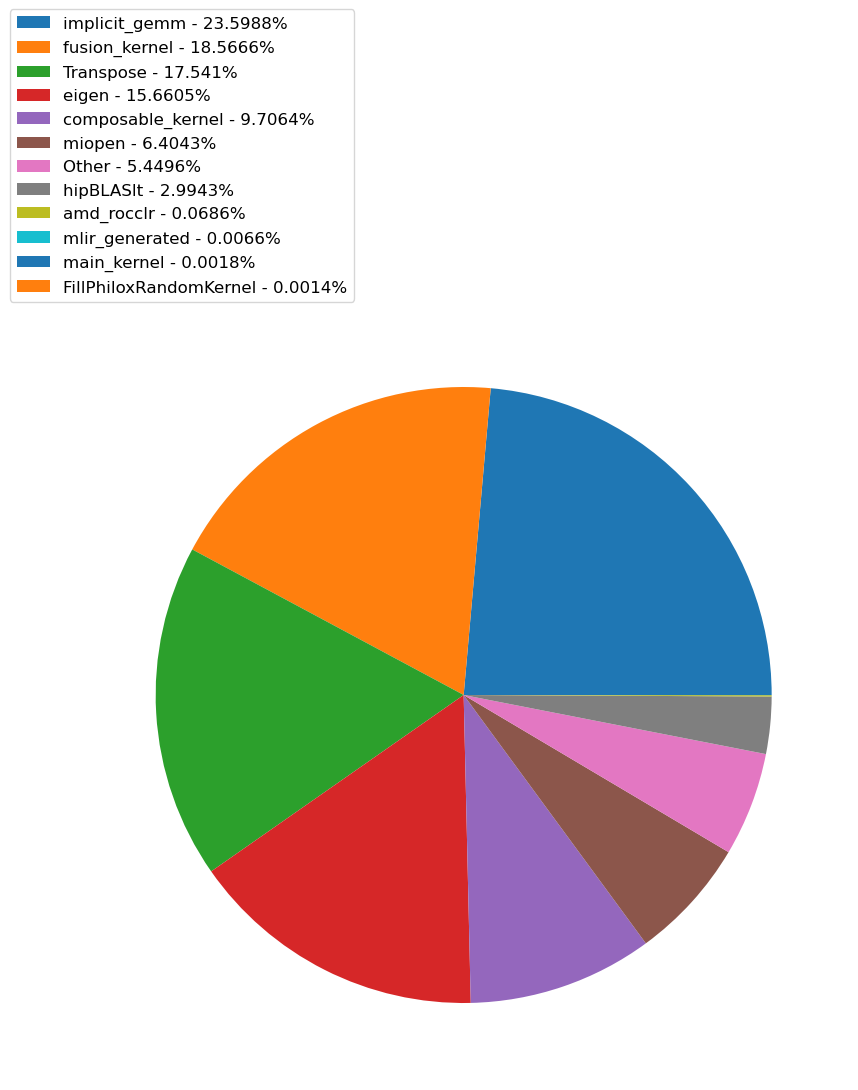

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
patches, texts = ax.pie(sorted['TotalPercentage'])
labels = sorted['Type'] + ' - ' + sorted['TotalPercentage'].round(4).astype(str) + "%"
plt.legend(patches, labels, loc='lower left', bbox_to_anchor=(-0.1, 1.),
           fontsize=12)
plt.show()

Text(0.5, 0, 'Type')

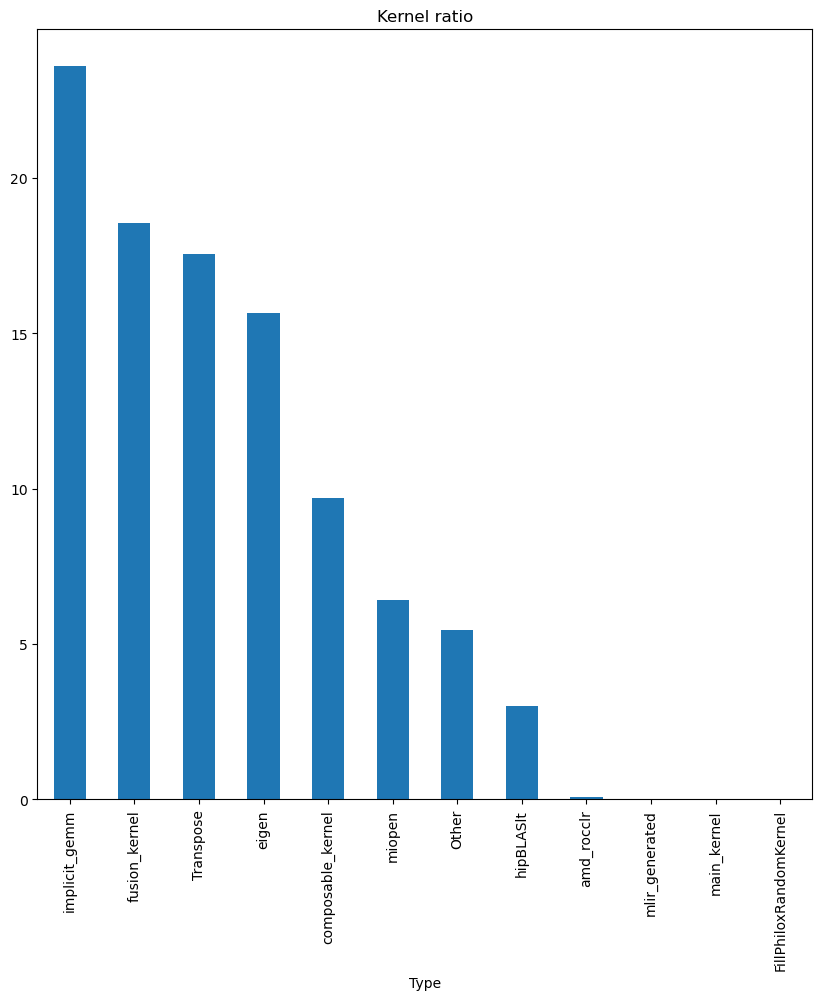

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sorted['TotalPercentage'].plot(kind='bar', title='Kernel ratio')
ax.set_xticklabels(sorted.Type)
plt.xlabel('Type')
